<a href="https://colab.research.google.com/github/Oukey/M_L/blob/master/myHW_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импортируем нужные модули:

In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
from torch.nn import Linear, Sigmoid
from torch import optim, nn

Задание гипер-параметров:

In [0]:
input_size = 28*28      # Размер изображения в точках
hidden_size = 500       # Количество нейронов в скрытом сое
num_classes = 10        # Количество распознающихся классов (10 цифр)
n_epochs = 2            # Количество эпох
batch_size = 4          # Размер мини-пакета входных данных
lr = 0.01               # Скорость обучения

Загрузка и проверка размеров датасетов

In [44]:
mnist_trainset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_testset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
'''
root - каталог размещения датасета
download - необходимость скачивания датасета
train - обучающий(True) или тестовый(False)
transform - трансформация, предваритеьная обработка
'''
print(len(mnist_trainset))  # вывод размера обучающего датасета
print(len(mnist_testset))  # вывод размера тестового датасета

60000
10000


Обработка датасета мини-пакетами

In [0]:
# Загрузчик обучающих данных
train_loader = torch.utils.data.DataLoader(dataset=mnist_trainset, batch_size=batch_size, shuffle=True)
# Загрузчик тестовых данных
test_loader = torch.utils.data.DataLoader(dataset=mnist_testset, batch_size=batch_size, shuffle=True)

Функция стандартного шага обучения

In [0]:
# Инициализация девайса
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def make_train_step(model, loss_fn, otpimizer):
    def train_step(x, y):
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step

Задание модели, вида оптимизации. Обучение и расчет лосса

In [47]:
model = torch.nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, num_classes))
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for images, labels in train_loader:
        # преобразование в одномерный вектор
        images = images.reshape(-1, 28*28).to(device)  
        images = images.to(device)
        labels = labels.to(device)
        loss = train_step(images, labels)
    print(epoch)

print('model', model.state_dict())
print('loss', loss)        

0
1
OrderedDict([('0.weight', tensor([[-1.6318e-02,  2.1214e-02, -1.8944e-02,  ...,  1.9201e-02,
          2.5679e-02, -1.6846e-02],
        [ 9.2470e-04, -2.5361e-02, -2.8592e-02,  ..., -3.0032e-02,
         -2.5984e-02, -3.5322e-02],
        [ 3.3203e-02,  2.7540e-02, -5.9779e-03,  ..., -6.8213e-03,
         -3.1774e-03, -3.2339e-02],
        ...,
        [ 3.5554e-02,  2.1658e-02, -3.3162e-02,  ..., -2.9766e-02,
          3.2393e-02,  3.0913e-02],
        [ 6.8806e-04, -4.1299e-03,  2.2662e-02,  ...,  3.2200e-02,
          1.2249e-02, -9.9145e-05],
        [ 1.3947e-02,  3.5485e-03, -1.9517e-02,  ..., -2.1468e-02,
          1.9904e-02, -1.3193e-02]])), ('0.bias', tensor([-1.7566e+00, -4.2776e-02, -5.3127e-02, -4.6501e-01, -6.0668e-02,
        -1.8455e-01, -4.4093e-02, -2.6608e-02, -3.1624e-01, -3.5950e-02,
        -9.1206e-02, -2.4765e-01, -8.8926e-02, -7.1994e-02, -5.7405e-02,
        -6.5990e-02, -9.6530e-02, -4.0080e-02, -9.1521e-02, -1.0315e+00,
        -3.5610e-01, -2.4026e-01,

Проверка точности обработки 10.000 тестовых изображений

In [50]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Точность: {}%'.format(100 * correct / total))

Точность: 92.6%


Сохранение обученной модели

In [0]:
torch.save(model, 'mnist_full.pt')

Загрузка модели

In [52]:
model = torch.load('mnist_full.pt')
model.eval()

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=10, bias=True)
)

Визуальная проверка обученной модели. Код выводит четыре случайных изображения из датасета и указывает под ними соответствующие им классы (прогноз), которые заданы в списке classes:

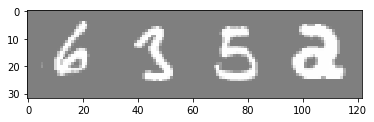

         6          3          5          2


In [76]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))